# Importation Station

In [124]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import ADASYN
from collections import Counter


plt.style.use("seaborn")
%matplotlib inline

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 6.45 ms


# Make DataFrame and Extract Features

## Read Initial Data

In [ ]:
# df= pd.read_csv("us-perm-visas.zip")
# df.head()

## Extract Features of Interest

In [ ]:
# df_feat=df[['class_of_admission','country_of_citizenship',
#             'country_of_citzenship','case_status', 'employer_state','foreign_worker_info_city',
#             'foreign_worker_info_education','foreign_worker_info_major',
#            'application_type', 'fw_info_birth_country', 'job_info_alt_occ_job_title','job_info_education',
#             'wage_offer_from_9089']]
# df_feat.head()
# del df

# Pickle and Store Features of Interest into CSV

In [ ]:
# with open('visa.pkl', 'wb') as picklefile:
#              pickle.dump(df_feat, picklefile)

In [ ]:
# with open("visa.pkl", 'rb') as picklefile: 
#       df = pickle.load(picklefile)
# df.to_csv('visa.csv')
# df.head()

# Read Pre-Made CSV File

In [ ]:
df=pd.read_csv('visa.csv')
del(df['Unnamed: 0'])
df.head()

# Begin Data Cleaning

## Combine Repeated Columns- Not Specific to Train/Test

In [ ]:
df.isnull().sum()

In [ ]:
df.country_of_citizenship.fillna(df.country_of_citzenship, inplace=True)
df=df.drop('country_of_citzenship', axis=1)
df.isnull().sum()

In [ ]:
df.foreign_worker_info_education.fillna(df.job_info_education, inplace=True)
df=df.drop('job_info_education', axis=1)
df.isnull().sum()

## Split into Train and Test Sets

In [ ]:
# X=df.drop(['case_status'],axis=1)
# y = df['case_status']

In [ ]:
# df_train, df_test= train_test_split(X,y,test_size=0.3)

## Fill Na's in Train Set
**Idea:**
1. Ignore Target Variable When Filling NA's
2. Fill in Test set With Train Values to Accurately Check Models

**Structure for Each Variable:**
1. Read Values Counts
2. Fill in As Needed

In [ ]:
def impute(df, series, col_name, merge_cols):
    merged_frame = pd.merge(df, series, how='left', 
                             left_on=merge_cols, 
                             right_on=merge_cols)
    merged_frame[col_name+'_x'].fillna(merged_frame[col_name+'_y'],inplace=True)
    merged_frame.rename(columns={col_name+'_x':col_name}, inplace=True)
    merged_frame.drop([col_name+'_y'], axis=1, inplace=True)
    return merged_frame

In [ ]:
def mode(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]

### Country of Citizenship= Fill using the mode by education level

In [ ]:
country_fill_series = df[~df['country_of_citizenship'].isnull()].groupby(['foreign_worker_info_education']
                                                                        ).country_of_citizenship.apply(mode
                                                                                                      ).reset_index()
country_fill_series

In [ ]:
df=impute(df, country_fill_series, 'country_of_citizenship',['foreign_worker_info_education'])
df.isnull().sum()

### Destination State= Fill using overall mode

In [ ]:
df.employer_state.unique()

In [ ]:
state_fill_series=df['employer_state'].mode()
state_fill_series

In [ ]:
df.employer_state.fillna('CALIFORNIA', inplace=True)
df.isnull().sum()

### Origin City= Fill using mode of given country

In [ ]:
df.foreign_worker_info_city.unique()

In [ ]:
origin_fill_series = df[~df['foreign_worker_info_city'].isnull()].groupby(['country_of_citizenship']
                                                                         ).foreign_worker_info_city.apply(mode
                                                                                                         ).reset_index()
origin_fill_series

In [ ]:
df = impute(df, origin_fill_series, 'foreign_worker_info_city',['country_of_citizenship'])
df.isnull().sum()

### Education Level= Fill using Country and Visa Type

In [ ]:
df.foreign_worker_info_education.unique()

In [ ]:
education_fill_series = df[~df['foreign_worker_info_education'].isnull()].groupby(['country_of_citizenship',
                                                                                   'class_of_admission']
                                                                                 ).foreign_worker_info_education.apply(mode
                                                                                                                      ).reset_index()
education_fill_series

In [ ]:
df = impute(df, education_fill_series, 'foreign_worker_info_education', ['country_of_citizenship',
                                                                                   'class_of_admission'])
df.isnull().sum()

### Major= Fill with mode of visa type / country of origin / education / destination

In [ ]:
df.foreign_worker_info_major.value_counts()

In [ ]:
major_fill_series = df[~df['foreign_worker_info_major'].isnull()].groupby(['country_of_citizenship',
                                                                               'class_of_admission',
                                                                               'foreign_worker_info_education',
                                                                               'employer_state']
                                                                             ).foreign_worker_info_major.apply(mode
                                                                                                              ).reset_index()
major_fill_series

In [ ]:
df = impute(df, major_fill_series, 'foreign_worker_info_major',['country_of_citizenship',
                                                                               'class_of_admission',
                                                                               'foreign_worker_info_education',
                                                                               'employer_state'])
df.isnull().sum()

### Birth Country= Fill with country of citizenship

In [ ]:
df.fw_info_birth_country.unique()

In [ ]:
df.fw_info_birth_country.fillna(df.country_of_citizenship, inplace=True)
df.isnull().sum()

### Job Title
1. Condense Job Titles into Categories
2. Fill in missing information using mode by major, education level, and class of admission

In [ ]:
df.job_info_alt_occ_job_title.value_counts()

In [ ]:
def label(row,col):
    if type(row[col])!=float:
        value=row[col].lower()
        value_case_sensitive=row[col]
    else:
        value='null'
        value_case_sensitive='null'
    programmer=['comp', 'software','developer', 'program','soft','web','application development', 'data']
    it=['IT','Information Technology','technical']
    h14=['H.14', 'H-14','H14','H. 14', 'H:14']
    medicine=['health','doctor','pharm','therapist','surgery','acupunc', 'medic', 'dent', 'vet']
    engineer=['engr','engineer','eng', 'tech']
    marketing=['market','sale']
    finance=['financ', 'consult','account','tax','audit']
    other_biz=['analyst', 'business','anlyst','associate','manag','project']
    academic=['analys', 'assistant', 'research', 'teach','academic', 'educ']
    related=['related occupation', 'related', 'any', 'similar','experience', 'alternate']
    h11=['H-11','H11','H.11', 'H. 11']
    fourteen=['14']
    nan=['null']
    if value=='null' or value_case_sensitive=='null':
        return None
    if any(keyword in value for keyword in programmer):
        return 'programming'
    if any(keyword in value_case_sensitive for keyword in it):
        return 'IT'
    if any(keyword in value_case_sensitive for keyword in h14):
        return 'H.14'
    if any(keyword in value for keyword in medicine):
        return 'medicine'
    if any(keyword in value for keyword in engineer):
        return 'engineer'
    if any(keyword in value for keyword in marketing):
        return 'marketing/sales'
    if any(keyword in value for keyword in finance):
        return 'finance/consulting/tax'
    if any(keyword in value for keyword in other_biz):
        return 'business'
    if any(keyword in value for keyword in academic):
        return 'academic'
    if any(keyword in value_case_sensitive for keyword in h11):
        return 'h11'
    if any(keyword in value for keyword in related):
        return 'related'
    if any(keyword in value_case_sensitive for keyword in fourteen):
        return '14'
    return 'Other'

In [ ]:
df['job_category']=df.apply (lambda row: label(row, 'job_info_alt_occ_job_title'),axis=1)
df.job_category.value_counts()

In [ ]:
df.job_info_alt_occ_job_title[df.job_category=="Other"].value_counts()

In [ ]:
df.head()

In [ ]:
job_type_fill_series = df[~df['job_category'].isnull()].groupby(['foreign_worker_info_major',
                                                                               'foreign_worker_info_education',
                                                                               'class_of_admission']
                                                                             ).job_category.apply(mode).reset_index()
job_type_fill_series

In [ ]:
df = impute(df, job_type_fill_series, 'job_category',['foreign_worker_info_major',
                                                                               'foreign_worker_info_education',
                                                                               'class_of_admission'])
df.isnull().sum()

In [ ]:
df=df.drop('job_info_alt_occ_job_title', axis=1)

### Visa Type (Class of Admission)

In [ ]:
df.class_of_admission.unique()

In [ ]:
visa_fill_series = df[~df['class_of_admission'].isnull()].groupby(['foreign_worker_info_education'
                                                                  ]).class_of_admission.apply(mode).reset_index()
visa_fill_series

In [ ]:
df = impute(df, visa_fill_series, 'class_of_admission',['foreign_worker_info_education'])
df.isnull().sum()

### Wage Offered= Fill with mean by job title, education level, and destination

In [ ]:
# df.wage_offer_from_9089.unique()

In [ ]:
# for element in df.wage_offer_from_9089:
#     if type(element)!=float:
#         element=element.replace(',','')

In [ ]:
# df[~df['wage_offer_from_9089'].isnull()].wage_offer_from_9089= df[~df['wage_offer_from_9089'].isnull()
#                                                                  ].wage_offer_from_9089.astype(float)

In [ ]:
# wage_fill_series = df[~df['wage_offer_from_9089'].isnull()].groupby(['job_category',
#                                                                                'foreign_worker_info_education',
#                                                                                'employer_state'
#                                                                                ]).wage_offer_from_9089.mean().reset_index()
# wage_fill_series

In [ ]:
# df = impute(df, wage_fill_series, 'wage_offer_from_9089',['job_category','foreign_worker_info_education',
#                                                                'employer_state'])
# df.isnull().sum()

### Application Filing Info (Application Type)

In [ ]:
# df.application_type.unique()

In [ ]:
df=df.drop(['application_type','wage_offer_from_9089'], axis=1)

In [ ]:
df.isnull().sum()

# Reset Types

In [ ]:
# df['system'] = df.system.astype(int)
# df['reviews'] = df.reviews.astype(int)
# df['release_date'] = df.release_date.astype(int)
# df['discount'] = df.discount.astype(int)
# df['price'] = df.price.astype(float)
# df['systems'] = df.systems.astype(list)

# Class Imbalances

## Visualize

In [118]:
number_data=df.case_status.value_counts()

time: 42.7 ms


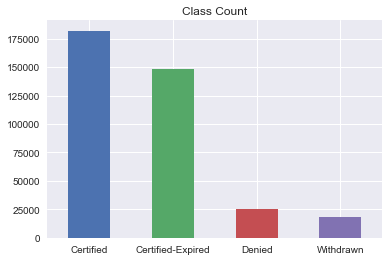

time: 603 ms


In [119]:
number_data.plot(kind='bar', title='Class Count', rot=0);


In [122]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

time: 2.66 ms


## ADASYN

In [126]:
Counter(df.case_status)

Counter({'Certified': 181933,
         'Denied': 25649,
         'Certified-Expired': 148586,
         'Withdrawn': 18194})

time: 35.7 ms


In [ ]:
Counter(df.case_status)

In [ ]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X,y)

In [125]:
Counter(df.case_status)

Counter({'Certified': 181933,
         'Denied': 25649,
         'Certified-Expired': 148586,
         'Withdrawn': 18194})

time: 31.8 ms


# Dummify Variables

In [ ]:
df2=df.drop(['foreign_worker_info_major', 'fw_info_birth_country'], axis=1)
df3=pd.get_dummies(df2)

# Store as CSV

In [ ]:
with open('clean_data1.pkl', 'wb') as picklefile:
             pickle.dump(df3, picklefile)

In [ ]:
with open("clean_data1.pkl", 'rb') as picklefile: 
      df = pickle.load(picklefile)
df.to_csv('clean_data1.csv')
df.head()